# Capstone Project:
## Late Delivery and Fraud Detection for e-commerce supply chain

Customer satisfaction is the bread and butter of ecommerce businesses. It is the repeat business that is most beneficial to e-commerce businesses and leads to maximum profit since there are no new acquisition costs involved in repeat business.<br>
Thus, prevention of customer churn, which is directly linked to customer satisfaction, is a key driver of a supply chain company's profitability.<br>

Our target business is an e-commerce supply chain business.  The business has two major concerns in its business operations:
1. It is facing high customer churn of unsatisfied customers due to late deliveries
2. It is facing losses due to fraudulent transactions<br>

The business has decided to consult a data driven analytics firm (us) and wants to figure out:
 -  Any insights they can find on their business in terms of their product catalog and customer base.
 -  Which customers can they target immediately to reduce churn and boost sales.
 -  Do any patterns emerge from their customer base and transactional data that can point to patterns in late deliveries and fraudulent transactions.
 - A prediction model that can predict late deliveries using the order/sale data before they occur.

Detecting late deliveries before they occur can greatly benefit the supply chain business by rerouting and taking proactive steps to ensure on-time delivery and can also set appropriate customer expectations in-terms of delivery time so that customers feel dissatisfied.<br>
A prediction algorithms for late deliveries will go a long way towards prevention of customer churn.<br>

The analysis in this notebook is aimed at providing solutions to the above problems and presents the following analysis:
 - Exploratory data analysis to detect trends in sales, product pricing and segments, markets and regions, and insights related to late delivery and fraudulent transactions
 - Customer segmentation analysis using RFM technique providing a systematic approach to customer loyalty programs.
 - A reliable machine Learning model that the company can deploy to detect late deliveries and improve customer satisfaction.

### Data Collection
The dataset used in this project is maintained transparently with the Creative Commons 4.0 license by Fabian Constante, Fernando Silva, and António Pereira through the Mendeley data repository. The dataset consists of roughly 180k transactions from supply chains used by the company DataCo Global for 3 years. The dataset can be downloaded from:<br>

https://data.mendeley.com/datasets/8gx2fvg2k6/5


### Data Wrangling

Importing all required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Importing Dataset using pandas
dataset=pd.read_csv("/content/gdrive/MyDrive/Springboard projects/Cap Project 2/Input/DataCoSupplyChainDataset.csv",
                    header= 0, encoding='unicode_escape')
dataset.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [4]:
dataset.shape

(180519, 53)

In [5]:
dataset.apply(lambda x: sum(x.isnull())) #Checking missing values

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


We see a few missing values in variables Customer Lname & Customer Zipcode and a large number of missing values in Order Zipcode and Product description. We address this.<br>
We also convert First Name and Last Name into Full Name variable to avoid amiguity and also address missing values of Customer Lname. We also create columns named 'Is Late' and 'Is Fraud' to identify the orders that we delivered late.

In [6]:
# Adding first name and last name together to create new column
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)

# Late orders
dataset['Is_Late'] = np.where(dataset['Days for shipping (real)'] > dataset['Days for shipment (scheduled)'], 1, 0)
#dataset['No. of Late'] = np.where(dataset['Days for shipping (real)'] > dataset['Days for shipment (scheduled)'], 
#                                  dataset['Days for shipping (real)'] > dataset['Days for shipment (scheduled)'], 0)

dataset['Is_Fraud'] = np.where(dataset['Order Status'] == 'SUSPECTED_FRAUD', 1, 0)

# Dropping unnecessary columns and ones with large missing values
data=dataset.drop(columns = ['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname',
                             'Customer Lname','Latitude','Longitude','Product Description','Product Image',
                             'Order Zipcode','shipping date (DateOrders)'])

# 3 NaNs of Custmer Zipcode replaced with 0. 
data['Customer Zipcode'] = data['Customer Zipcode'].fillna(0)

data.shape

(180519, 44)

There looks like duplication of information in different columns. Lets identify and remove these.

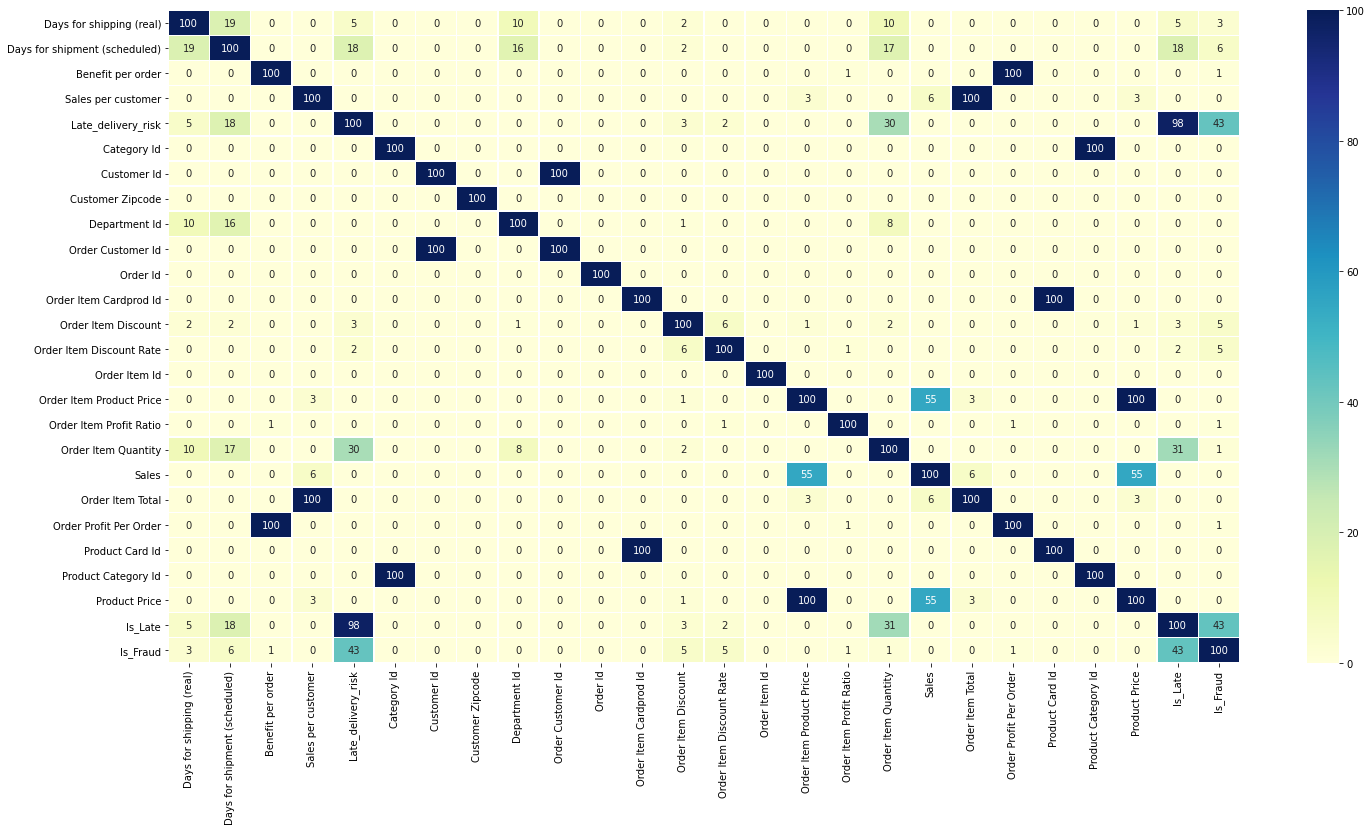

In [7]:
# Comparison function for columns. Returns dataframe with percentage of values that differ
def diff_matrix(df):
    df_num = df.select_dtypes(include='number')
    diff_matrix = pd.DataFrame(columns=df_num.columns)
    for col_row in df_num.columns:
        for col_col in df_num.columns:
            diff_matrix.loc[col_row, col_col] = (df_num[col_row] == df_num[col_col]).sum()*100/len(df_num)
    diff_matrix = diff_matrix.astype('float')
    return diff_matrix

x = diff_matrix(data)
plt.subplots(figsize=(24, 12))
sns.heatmap(x, annot=True, fmt='.0f', cmap='YlGnBu', linewidth=0.5)
plt.show()

In [8]:
data = data.drop(columns=['Order Profit Per Order', 'Product Category Id', 'Order Customer Id', 
                          'Order Item Cardprod Id', 'Order Item Product Price', 'Sales per customer'])

In [9]:
data.shape

(180519, 38)

### Exploratory Data Analysis

Lets look at the correlation characteristics between the numerical variables

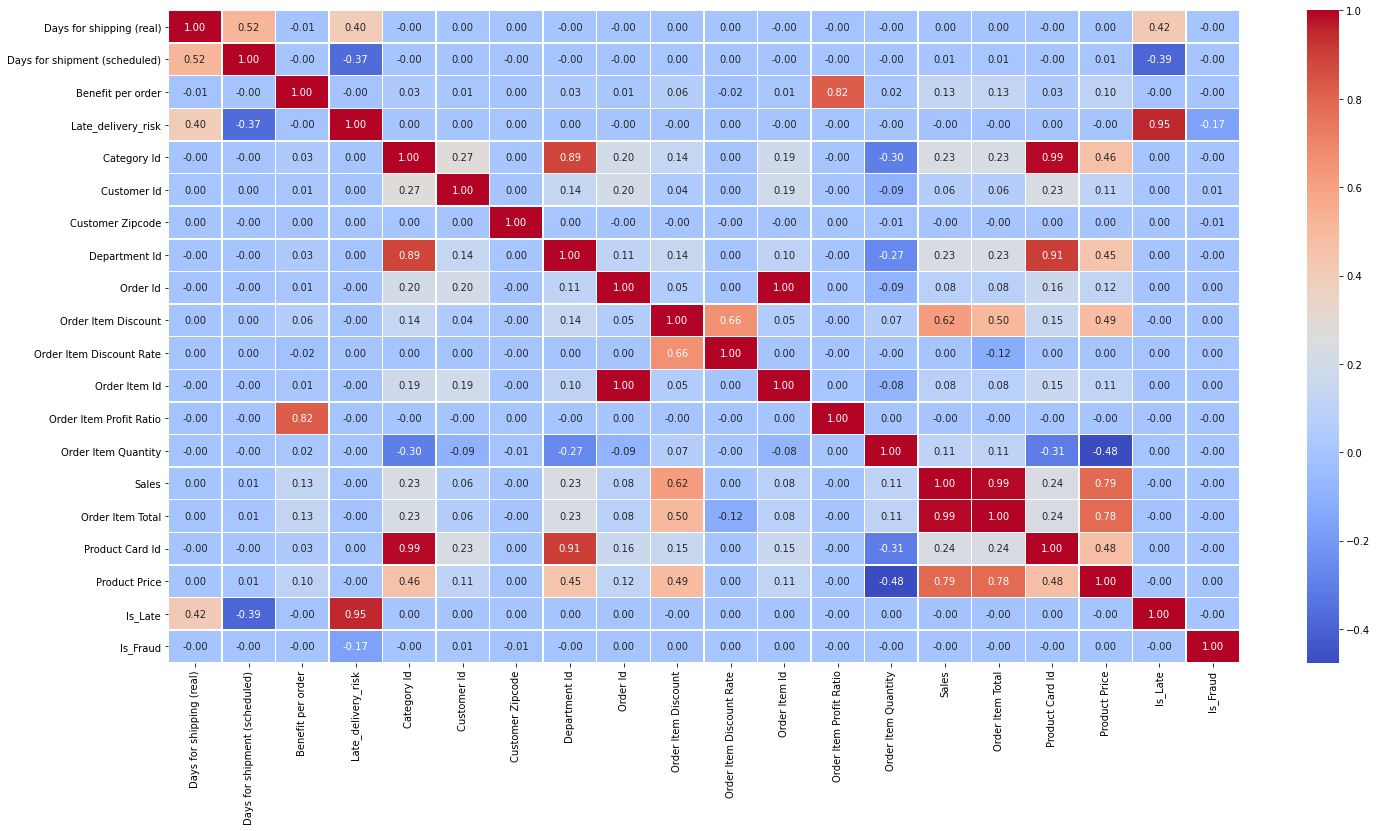

In [10]:
fig, ax = plt.subplots(figsize=(24,12))
c = data.corr()
sns.heatmap(c, annot=True, fmt='.2f', linewidths=0.5, cmap='coolwarm')
plt.show()

The features we are interested in are:
1. Days for shipping (real)
2. Is Late
3. Sales
4. Benefit per order
5. Order Status - This feature tells us about the fraudulent transactions

#### Sales by Continent and Sales by Region:
Lets take a look at the sales vs region and see what insights we can find from it.<br>

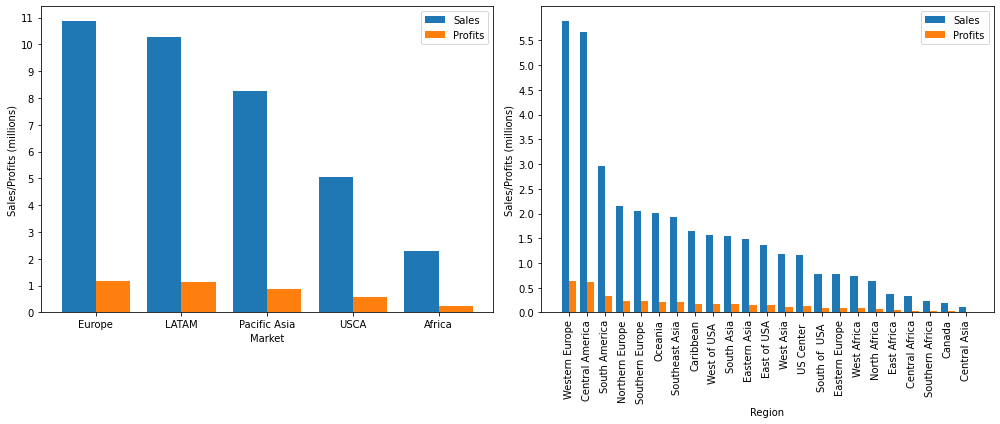

In [11]:
# Data
market = data.groupby('Market')
region = data.groupby('Order Region')
# Sales and Profits by Market plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
markets = market['Sales'].sum().sort_values(ascending=False).index
ticks = np.arange(len(markets))
bar_width = 0.4
ax1.bar(ticks, market['Sales'].sum().reindex(markets), width=bar_width, label='Sales')
ax1.bar(ticks+bar_width, market['Benefit per order'].sum().reindex(markets), width=bar_width, label='Profits')
ax1.set(label='Sale and Profit by Market', xlabel='Market', ylabel='Sales/Profits (millions)', xticks=ticks+bar_width/2, 
        xticklabels=markets, yticks=np.arange(0, 12e6, 1e6), yticklabels=np.arange(0, 12, 1))
ax1.legend()
# Sales and Profits by Region plot
regions = region['Sales'].sum().sort_values(ascending=False).index
ticks = np.arange(len(regions))
bar_width = 0.4
ax2.bar(ticks, region['Sales'].sum().reindex(regions), width=bar_width, label='Sales')
ax2.bar(ticks+bar_width, region['Benefit per order'].sum().reindex(regions), width=bar_width, label='Profits')
ax2.set(label='Sale and Profit by Region', xlabel='Region', ylabel='Sales/Profits (millions)', xticks=ticks+bar_width/2, 
        yticks=np.arange(0, 6e6, 0.5e6), yticklabels=np.arange(0, 6, 0.5))
ax2.set_xticklabels(regions, rotation=90)
ax2.legend()
#region['Sales'].sum().sort_values(ascending=False).plot.bar(title="Total sales for all regions", ax=ax2)
plt.legend()
plt.tight_layout()
plt.show()

It can be seen from the graph that European market has the most number of sales followed by Latin America whereas Africa has the least. In these markets western europe regions and central america recorded highest sales.

#### Sales by Product Category:

Next we take a look at which catergory of products has highest sales?

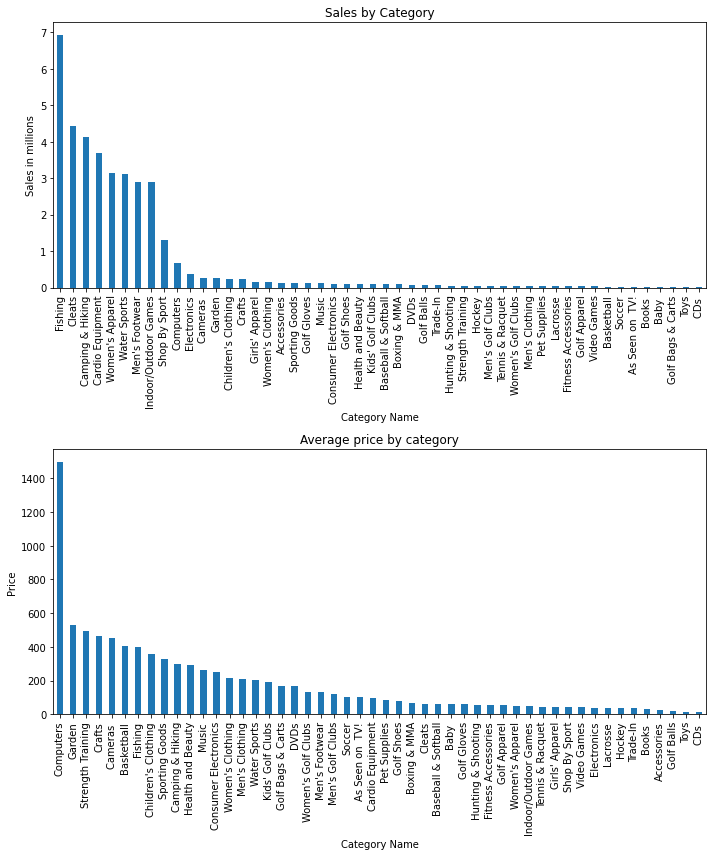

In [12]:
cat = data.groupby('Category Name')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
# Total sum of sales for all categories
cat['Sales'].sum().sort_values(ascending=False).plot.bar(ax=ax1)
ax1.set(title="Sales by Category", ylabel='Sales in millions', yticks=np.arange(0, 8e6, 1e6), yticklabels=np.arange(0, 8, 1))
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(ax=ax2)
ax2.set(title="Average price by category", ylabel='Price')
plt.tight_layout()
plt.show()

As we can see from the above figure, Fishing category had most number of sales followed by the Cleats. <br>
As for the average product prices, Computers leads the numbers followed by Garden equipment.

#### Sales vs Product Price:
We observed a strong correlation (0.79) between Sales per product (Sales) and Price of the product (Price) in the correlation heatmap.<br>
Lets look at that correlation.

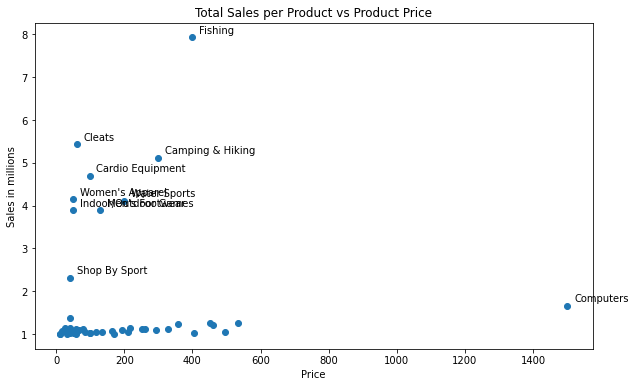

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(cat['Product Price'].mean(), cat['Sales'].sum())
top_10 = list(cat['Sales'].sum().sort_values(ascending=False)[:10].index)
for item in top_10:
    ax.annotate(item, (cat['Product Price'].mean()[item] + 20, cat['Sales'].sum()[item] + 100000))
ax.set(title='Total Sales per Product vs Product Price', ylabel='Sales in millions', xlabel='Price', 
       yticklabels=np.arange(0, 9, 1))
plt.show()

We can observe some overlap between the top products in terms of total sales and average price.<br> Although the top selling products seem to be driven by consumer demand than anything else and no causation exists between the product price and product sales.<br> We can say that demand is the primary factor driving the sales of a product category.

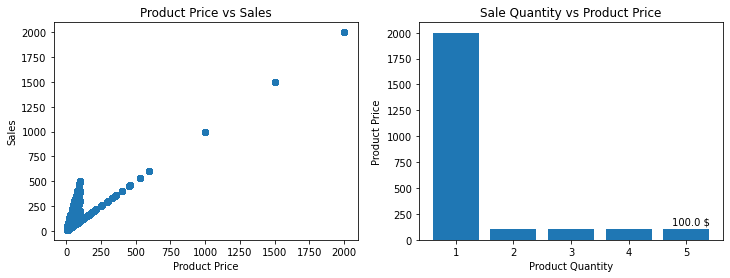

In [14]:
#Quantity bought per product sale.
qty = (data['Sales']/data['Product Price']).round()  
# Maximum Price of the item sold for that quantity
maxP_per_qty = [data[qty==n]['Product Price'].max() for n in qty.unique()]  

fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].scatter(x=data['Product Price'], y=data['Sales'])
ax[0].set(title='Product Price vs Sales', xlabel='Product Price', ylabel='Sales')
ax[1].bar(qty.unique(), maxP_per_qty)
ax[1].set(title='Sale Quantity vs Product Price', xlabel='Product Quantity', ylabel='Product Price')
ax[1].annotate(str(data[qty!=1]['Product Price'].max())+' $', (4.75, data[qty!=1]['Product Price'].max()+50))
plt.show()

Considering the nature of the dataset, the transaction of each item in a sale is recorded as a seperate entry. We can observe something interesting about the buying pattern of the customers looking at the maximum product price vs product quantity purchased. From the figure on the right we can see that customers bought more than 1 nos. (2, 3, 4 & 5) of only those items which are within the 100$ price brand. Hence we see that the slope of the scatter plot is steeper in that region.<br>
This is an interesting insight in terms of consumer behaviour and can be used to pivot or boost sales on the platform.

#### Sales and Profits vs Time Periods:
Lets find time trends for Sales and identify the busiest periods for sales.<br>
We split the 'order date' into year, month, day and hour and add these columns to our database for groupby operations

In [15]:
date_index = pd.to_datetime(data['order date (DateOrders)'].tolist())
data['order_year']= date_index.year
data['order_month'] = date_index.month
data['order_week_day'] = date_index.weekday
data['order_week'] = date_index.week
data['order_hour'] = date_index.hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

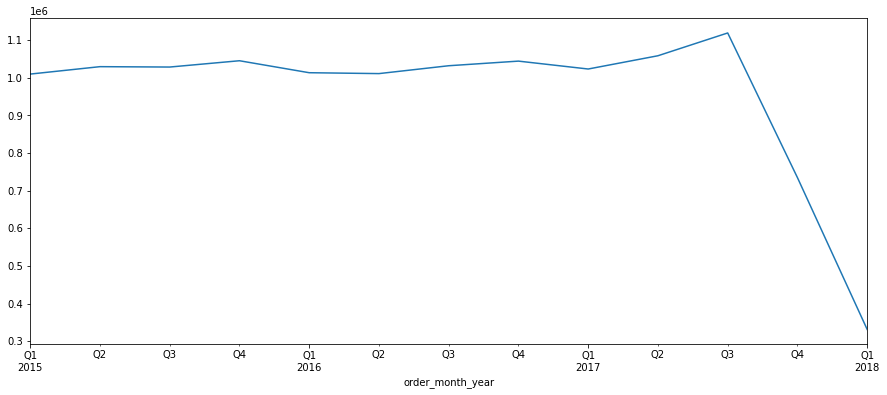

In [16]:
quater= data.groupby('order_month_year')
quater['Sales'].sum().resample('Q').mean().plot(figsize=(15,6))

We observe from the above graph that sales were consistent from Q1 2015 until Q3 of 2017 but suddenly dipped in Q4 2017 and Q1 2018.<br>
Its worth examining what caused this dip.<br>

Lets look at the purchase trend in week days, hours and months.

In [17]:
# Calculating the numbers.
# Total Sales & Profit per year
total_sale_year = data.groupby('order_year').sum()['Sales']
total_profit_year = data.groupby('order_year').sum()['Benefit per order']
# Total Sales & Profit in a month averaged over year
avg_sale_month = data.groupby(['order_month', 'order_year']).sum().groupby(level=0).mean()['Sales']
avg_profit_month = data.groupby(['order_month', 'order_year']).sum().groupby(level=0).mean()['Benefit per order']
# Total Sales & Profit in a week averaged over year
avg_sale_week = data.groupby(['order_week', 'order_year']).sum().groupby(level=0).mean()['Sales']
avg_profit_week = data.groupby(['order_week', 'order_year']).sum().groupby(level=0).mean()['Benefit per order']
# Total Sales & Profit on a day of the week average by week
avg_sale_weekday = data.groupby(['order_week_day', 'order_week']).sum().groupby(level=0).mean()['Sales']
avg_profit_weekday = data.groupby(['order_week_day', 'order_week']).sum().groupby(level=0).mean()['Benefit per order']

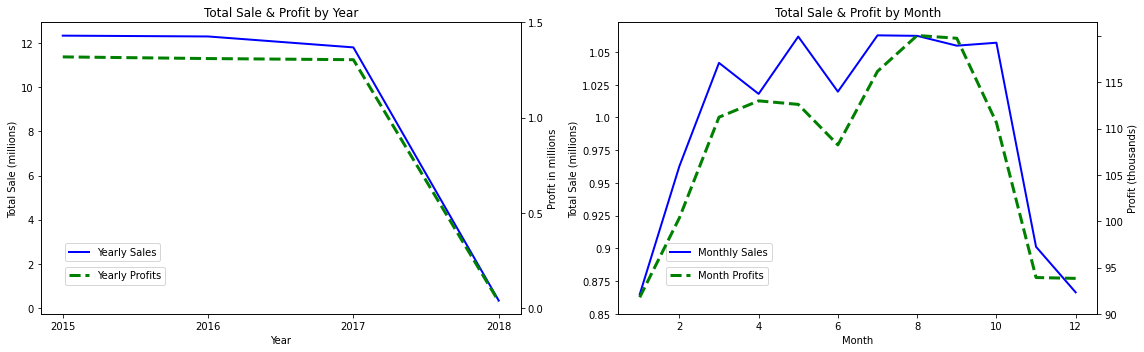

In [18]:
# Ploting yearly and monthly figures
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
axa = ax[0].twinx()
total_sale_year.plot(c='b', lw=2, alpha=1, ax=ax[0])
total_profit_year.plot(c='green', ls='--', lw=3, alpha=1, ax=axa)
ax[0].set(title='Total Sale & Profit by Year', xlabel='Year', ylabel='Total Sale (millions)', 
          xticks=total_sale_year.index, xticklabels=total_sale_year.index, yticks=np.arange(0, 1.4e7, 0.2e7),
         yticklabels=np.arange(0, 14, 2))
axa.set(ylabel='Profit in millions', yticks=np.arange(0, 2e6, 0.5e6), yticklabels=np.arange(0, 2, 0.5))
ax[0].legend(['Yearly Sales'], loc=(0.05, 0.18))
axa.legend(['Yearly Profits'], loc=(0.05, 0.1) )

axb = ax[1].twinx()
avg_sale_month.plot(c='b', lw=2, alpha=1, ax=ax[1])
avg_profit_month.plot(c='green', ls='--', lw=3, alpha=1, ax=axb)
ax[1].set(title='Total Sale & Profit by Month', xlabel='Month', ylabel='Total Sale (millions)',
          yticks=np.arange(8.5e5, 10.75e5, 0.25e5), yticklabels=np.around(np.arange(0.85, 1.075, 0.025), 3))
axb.set(ylabel='Profit (thousands)', yticks=np.arange(9.0e4, 12.5e4, 0.5e4), yticklabels=np.arange(90, 120, 5))
ax[1].legend(['Monthly Sales'], loc=(0.1, 0.18))
axb.legend(['Month Profits'], loc=(0.1, 0.1))

plt.tight_layout()
plt.show()


We can see from the plot above that the yearly sale and profit are proportional and the sales and dip to 0 in the 1st quarter of 2018. This could result from hinderance of operations due to reasons such as financial shortages.<br>
From the total monthly sales averaged over the years, we see that maximum sale happens from March till October. The months of January and December have the least sales.<br>
As far as the profits are concerned we see an increment in the 2nd half of the year, typically picking up after June, which is the worst month for profits in between March and October.

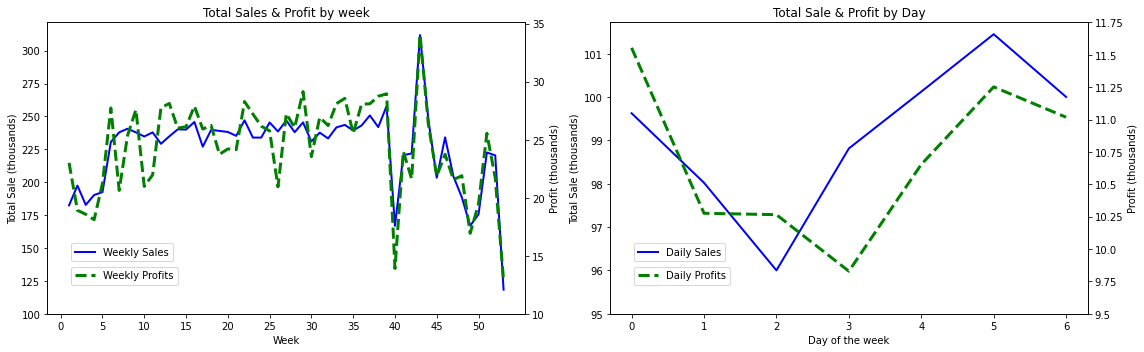

In [19]:
# Plotting weekly and daily numbers
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
axa = ax[0].twinx()
avg_sale_week.plot(c='b', lw=2, alpha=1, ax=ax[0])
avg_profit_week.plot(c='green', ls='--', lw=3, alpha=1, ax=axa)
ax[0].set(title='Total Sales & Profit by week', xlabel='Week', ylabel='Total Sale (thousands)', 
          xticks=np.arange(0, 53, 5), xticklabels=np.arange(0, 53, 5), yticks=np.arange(1.0e5, 3.25e5, 0.25e5),
         yticklabels=np.arange(100, 325, 25))
axa.set(ylabel='Profit (thousands)', yticks=np.arange(1.0e4, 4.0e4, 0.5e4), yticklabels=np.arange(10, 40, 5))
ax[0].legend(['Weekly Sales'], loc=(0.05, 0.18))
axa.legend(['Weekly Profits'], loc=(0.05, 0.1) )

axb = ax[1].twinx()
avg_sale_weekday.plot(c='b', lw=2, alpha=1, ax=ax[1])
avg_profit_weekday.plot(c='green', ls='--', lw=3, alpha=1, ax=axb)
ax[1].set(title='Total Sale & Profit by Day', xlabel='Day of the week', ylabel='Total Sale (thousands)',
          yticks=np.arange(9.5e4, 10.2e4, 0.1e4), yticklabels=np.arange(95, 102, 1))
axb.set(ylabel='Profit (thousands)', yticks=np.arange(9.5e3, 12.0e3, 0.25e3), yticklabels=np.arange(9.5, 12, 0.25))
ax[1].legend(['Daily Sales'], loc=(0.05, 0.18))
axb.legend(['Daily Profits'], loc=(0.05, 0.1))

plt.tight_layout()
plt.show()


Looking at the weekly sales, it reflects what we have gathered from the monthly sales i.e. the sales dip during the start and end of the year. We see consistent sales till week 39 after which we see large fluctuations from week 40 to 51. This is most probably reflective of the consumer behaviour in and around the festive weeks during the last few months of the year.<br>
The daily Sales show clearly that weekends have the highest sales and profits. Tuesday has the lowest sale and wednesday has the lowest profits. This could be due to discounts offered.

#### EDA of Payment Methods:
It is also important to know what type of payment methods are being preferred by consumers for purchase of these products. We look at these payment methods distributed over geographical regions

In [20]:
# Types of payment methods
print(data['Type'].unique())

['DEBIT' 'TRANSFER' 'CASH' 'PAYMENT']


It is found that four types of payment methods are used.Which payment method is preferred the most by people in different regions?

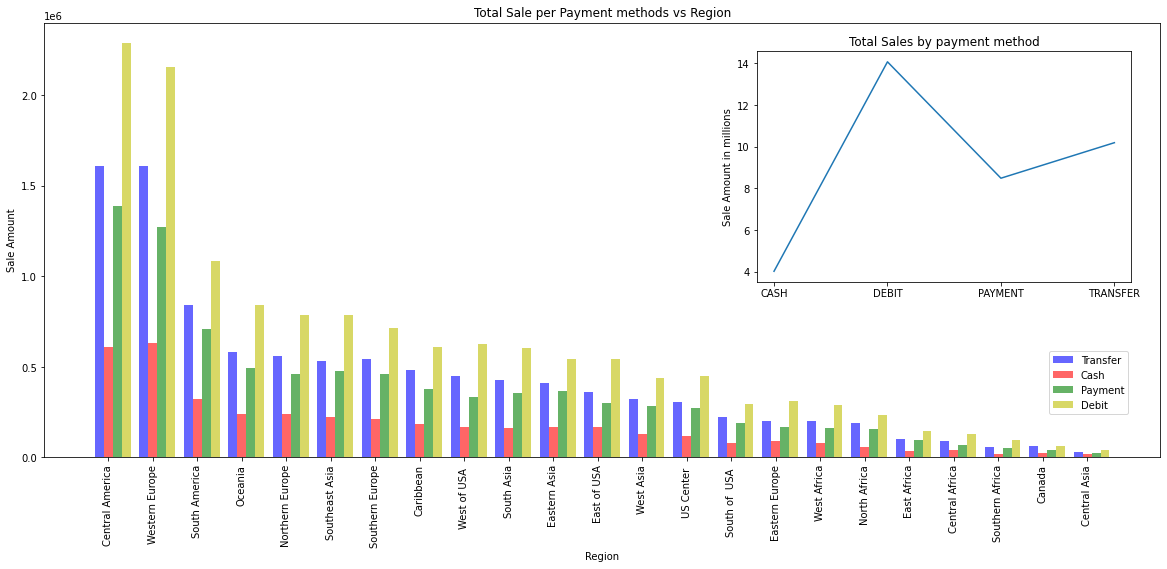

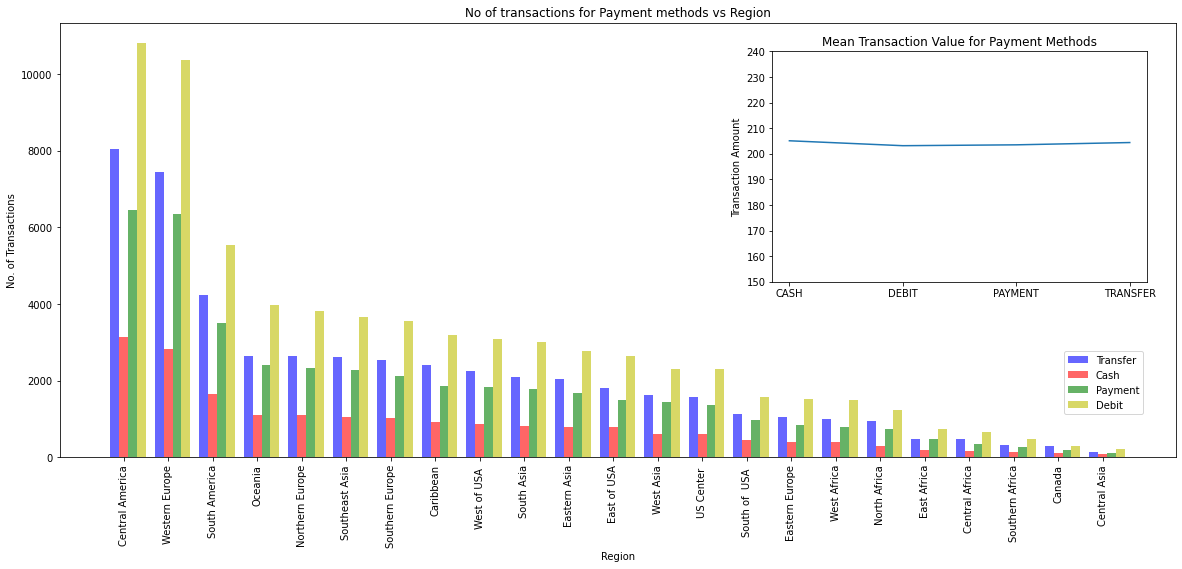

In [21]:
# Plotting number of transactions for each payment method for different regions
# Total Sale by region for each transaction type --
s_transfer = data[(data['Type'] == 'TRANSFER')].groupby('Order Region').sum()['Sales'].reindex(regions)
s_cash = data[(data['Type'] == 'CASH')].groupby('Order Region').sum()['Sales'].reindex(regions)
s_payment = data[(data['Type'] == 'PAYMENT')].groupby('Order Region').sum()['Sales'].reindex(regions)
s_debit = data[(data['Type'] == 'DEBIT')].groupby('Order Region').sum()['Sales'].reindex(regions)

# No. of transactions by region for each transaction type -- 
n_transfer = data[(data['Type'] == 'TRANSFER')]['Order Region'].value_counts()
n_cash = data[(data['Type'] == 'CASH')]['Order Region'].value_counts()
n_payment = data[(data['Type'] == 'PAYMENT')]['Order Region'].value_counts()
n_debit = data[(data['Type'] == 'DEBIT')]['Order Region'].value_counts()

regions = data['Order Region'].value_counts().index
index = np.arange(len(regions))
bar_width=0.2
opacity=0.6

# Plotting total sales by transaction type, by region
fig1,ax1 = plt.subplots(figsize=(20,8))
ax1.bar(index, s_transfer, bar_width, alpha=opacity, color='b', label='Transfer')
ax1.bar(index+bar_width, s_cash, bar_width, alpha=opacity, color='r', label='Cash')
ax1.bar(index+2*bar_width, s_payment, bar_width, alpha=opacity, color='g', label='Payment')
ax1.bar(index+3*bar_width, s_debit, bar_width, alpha=opacity, color='y', label='Debit')
ax1.set(title='Total Sale per Payment methods vs Region', xlabel='Region', ylabel='Sale Amount',
      xticks=index+bar_width)
ax1.set_xticklabels(regions, rotation=90)
# Total Sales by transaction type
ax2 = fig1.add_axes([0.62, 0.43, 0.26, 0.4])
ax2.plot(data.groupby('Type').sum()['Sales'])
ax2.set(title='Total Sales by payment method', ylabel='Sale Amount in millions', yticklabels=np.arange(2, 16, 2))
ax1.legend(loc=(0.9, 0.1))

# Plotting Number of transactions by transaction type by region
fig3,ax3 = plt.subplots(figsize=(20,8))
ax3.bar(index, n_transfer, bar_width, alpha=opacity, color='b', label='Transfer')
ax3.bar(index+bar_width, n_cash, bar_width, alpha=opacity, color='r', label='Cash')
ax3.bar(index+2*bar_width, n_payment, bar_width, alpha=opacity, color='g', label='Payment')
ax3.bar(index+3*bar_width, n_debit, bar_width, alpha=opacity, color='y', label='Debit')
ax3.set(title='No of transactions for Payment methods vs Region', xlabel='Region', ylabel='No. of Transactions',
      xticks=index+bar_width)
ax3.set_xticklabels(regions, rotation=90)
# Mean value of transaction by type
ax4 = fig3.add_axes([0.62, 0.43, 0.26, 0.4])
ax4.plot(data.groupby('Type').mean()['Sales'])
ax4.set(title='Mean Transaction Value for Payment Methods', ylabel='Transaction Amount', 
        yticks=np.arange(150, 250, 10), yticklabels=np.arange(150, 250, 10))
ax3.legend(loc=(0.9, 0.1))


plt.show()

Debit type is most preferred payment method by people throughout all regions, Cash payment being the least preferred method.<br> This is reflected in both the number of transactions and the transaction amount.<br>
We also observe that the mean amount for each transaction type is nearly the same (~ 205$)

#### Loss and Fraudulent Transactions:
Some products are having negative benefit per orders which indicates that the orders are generating loss of revenue to the company. Which products are these?<br>
First we take a look at the profit by category.

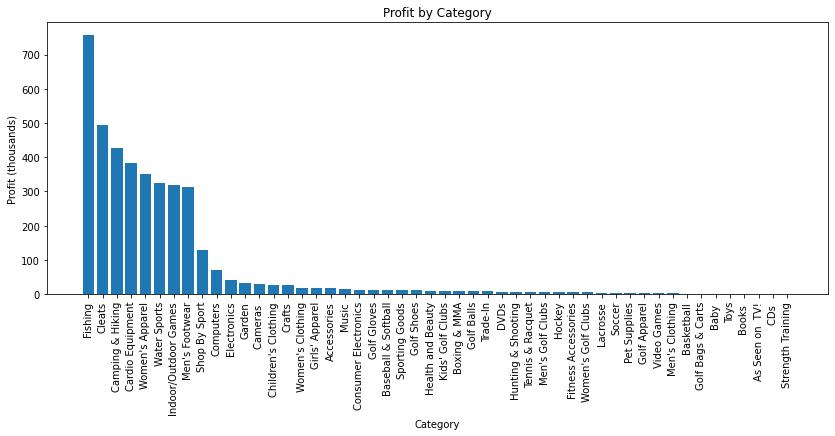

In [22]:
# Profit by Category
profit_cat = data.groupby('Category Name')['Benefit per order'].sum().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(np.arange(len(profit_cat)), profit_cat)
ax.set(title='Profit by Category', xlabel='Category', ylabel='Profit (thousands)', yticklabels=np.arange(0, 800, 100),
      xticks=np.arange(len(profit_cat)))
ax.set_xticklabels(profit_cat.index, rotation=90)
plt.show()

Next we analyze the loss making categories

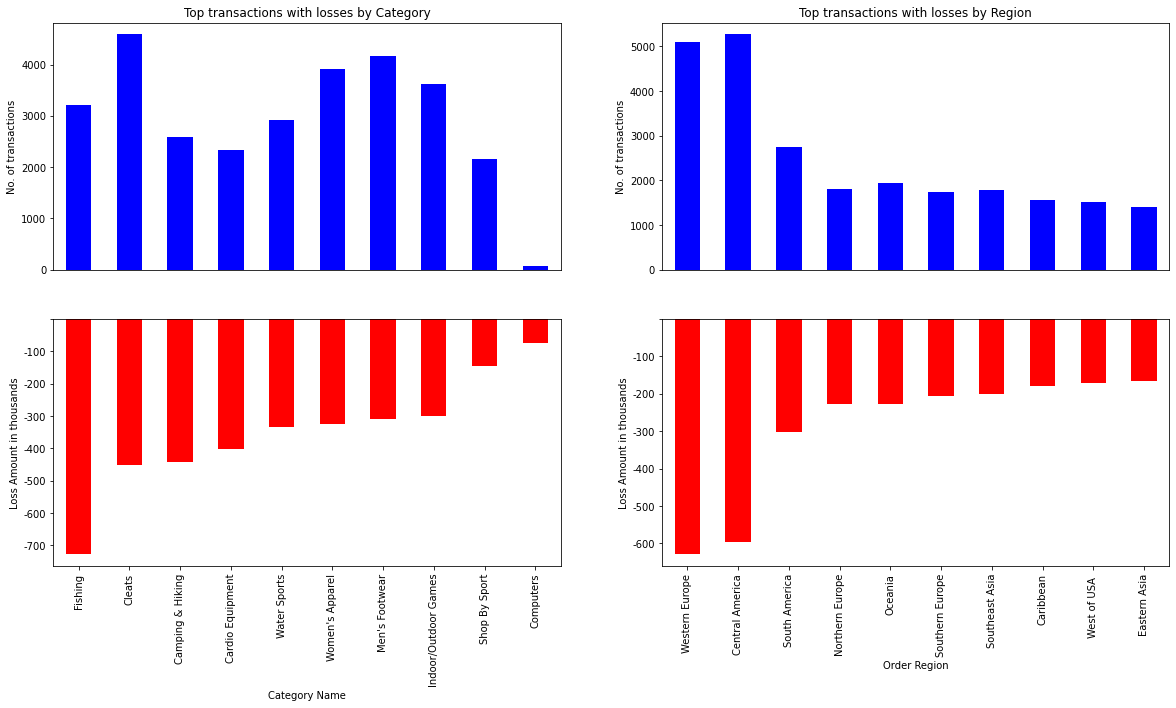

Total losses recorded: -3883547


In [23]:
loss = data[data['Benefit per order']<0]

#Plotting top 10 products with most loss
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs = axs.flat
max_loss_cat = loss.groupby('Category Name').sum()['Benefit per order'].nsmallest(10)
loss['Category Name'].value_counts()[max_loss_cat.index].plot.bar(ax=axs[0], color='b')
max_loss_cat.plot.bar(ax=axs[2], color='r')
axs[0].set(title='Top transactions with losses by Category', ylabel='No. of transactions')
axs[0].xaxis.set_visible(False)
axs[2].set(ylabel='Loss Amount in thousands', yticklabels=np.arange(-800, 0, 100))

# Plotting top 10 Regions with max losses
max_loss_reg = loss.groupby('Order Region').sum()['Benefit per order'].nsmallest(10)
loss['Order Region'].value_counts()[max_loss_reg.index].plot.bar(ax=axs[1], color='b')
max_loss_reg.plot.bar(ax=axs[3], color='r')
axs[1].set(title='Top transactions with losses by Region', ylabel='No. of transactions')
axs[1].xaxis.set_visible(False)
axs[3].set(ylabel='Loss Amount in thousands', yticklabels=np.arange(-700, 0, 100))
plt.show()
print('Total losses recorded: %d'%loss['Benefit per order'].sum())

The total loss sales are approximately 3.9 Millions which is an huge amount.<br>
It can be seen that Cleats is the category with maximum frequency of loss generating transactions followed by Mens footwear.<br>
Fishing records the highest amount lost in loss generating transactions.<br>
Most lost sales are happeing in Western Europe & Central America region. This lost sales may have happened due to suspected frauds or late deliveries.

#### EDA of Fraudulent Transactions

We explore which payment method has the highest probability of fraudulent transactions.

In [24]:
data[data['Order Status'] == 'SUSPECTED_FRAUD']['Type'].value_counts()

TRANSFER    4062
Name: Type, dtype: int64

It can be clearly seen that frauds are only being conducted with TRANSFER Type of Transactions. DEBIT, CASH & PAYMENT methods show no suspected fraudulent transactions.<br>
Are these transactions being conducted from abroad? Which region and what product is being suspected to the fraud the most?

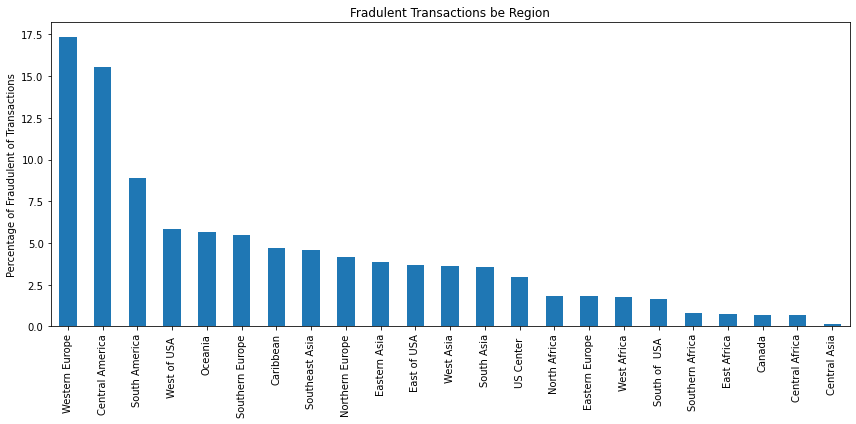

In [25]:
susp_fraud = data[data['Order Status'] == 'SUSPECTED_FRAUD']['Order Region'].value_counts()
susp_fraud_pct = susp_fraud*100/susp_fraud.sum()
# No of fraudulent transactions by region
susp_fraud_pct.plot.bar(figsize=(12, 6))
plt.title('Fradulent Transactions be Region')
plt.ylabel('Percentage of Fraudulent of Transactions')

plt.tight_layout()
plt.show()

It can be observed that highest number of suspected fraud orders are from Western Europe which is approximately 17.4% of total orders followed by Central America with 15.5%. Which product is being suspected fraud the most?

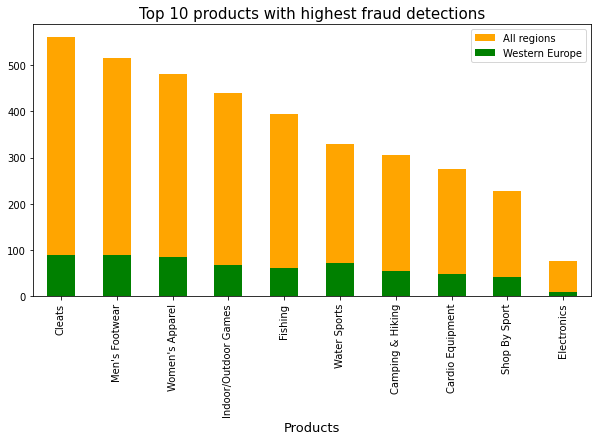

In [26]:
cat_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD')]['Category Name'].value_counts()
WEU_cat_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]\
                     ['Category Name'].value_counts().reindex(cat_fraud.index)

# Bar chart for top 10 most suspected fraud department in all regions
cat_fraud[:10].plot.bar(figsize=(10,5), title="Fraud Category",color='orange')
# Bar chart for top 10 most suspected fraud department in Western Europe
WEU_cat_fraud[:10].plot.bar(figsize=(10,5), title="Fraud product in Western Europe",color='green')

plt.legend(["All regions", "Western Europe"])
plt.title("Top 10 products with highest fraud detections", size=15)
plt.xlabel("Products", size=13)
plt.show()

Cleats department is being suspected of fraud the most followed by Men's footwear in all the regions and also in Western Europe.<br> 
Lets look at the consumers who are suspected of fraud.

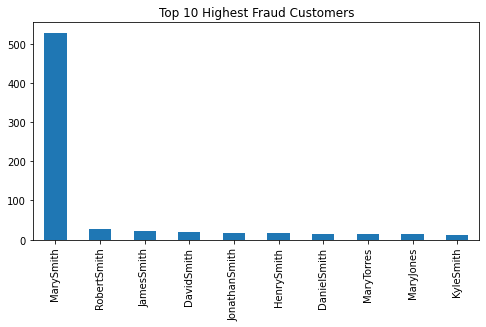

In [27]:
#Top 10 customers with most fraud
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] 
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(8,4), title="Top 10 Highest Fraud Customers")
plt.show()

Looks like the customer named Mary Smith alone was responible for trying to conduct fraud 528 times which is very shocking.<br>How much amount exactly did she conduct fraud orders?

In [28]:
MarySmith_amt = data[(data['Customer Full Name'] == 'MarySmith')&(data['Order Status'] == 'SUSPECTED_FRAUD')]\
                ['Sales'].sum()
print('Total fraudulent transactions by Mary Smith: %d'%MarySmith_amt)

Total fraudulent transactions by Mary Smith: 102491


In [30]:
print('No of transactions by Mary Smith: ', len(data[data['Customer Full Name']=='MarySmith']))
print('No of Customer Ids registered to Mary Smith :', data[data['Customer Full Name']=='MarySmith']['Customer Id'].count())

No of transactions by Mary Smith:  23884
No of Customer Ids registered to Mary Smith : 23884


The total amount was almost 102k which is very huge amount. Looks like Mary was using different address every time when placing orders, a new customer id was issued each time which makes it difficult to identify the customer and ban them. All these parameters should be taken into consideration to improve fraud detection algorithm so fraud can be identified more accurately.<br><br>

#### Logistics Efficacy Analysis

Delivering products to customer on time without late delivery is another important aspect for a supply chain company and is a big driver for customer satisfaction. What category of products are being delivered late the most?

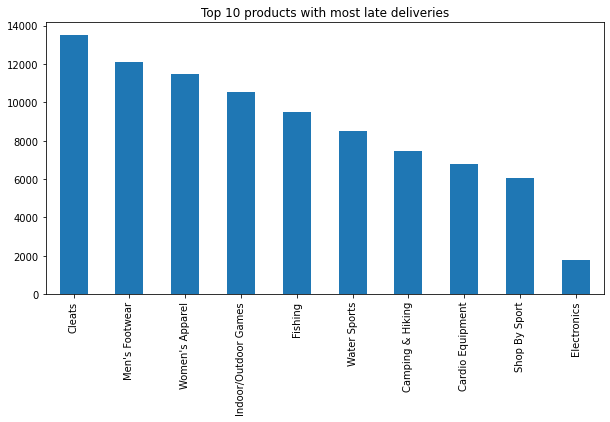

In [31]:
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
#Top 10 products with most late deliveries
_ = late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(10,5), 
                                                                title="Top 10 products with most late deliveries")


It can be seen that orders with Cleats department is getting delayed the most followed by Men's Footwear.<br>
Lets see how well is this late delivery predicted through the 'Late_delivery_risk' data that is already present in the dataset

In [32]:
pct = '%'
print('Accuracy of Risk Detection : %.2f'%((data['Late_delivery_risk'] == data['Is_Late']).sum()*100/len(data)), pct)


Accuracy of Risk Detection : 97.55 %


The late deliveries are actually being predicted in advance but it seems that either it is not possible to mitigate the risk or the data 'Late_delivery_risk' is being generated post dispatch by gathering delivery information.<br>
Incase it is the earlier and the prediction algorithm does predict late deliveries in advance, there need to be processes set in place such as alternate routing or increased scheduling, that can mitigate the delivery risk and avoid late deliveries.

Lets take a look at how different shipping modes perform in terms of on-time delivery

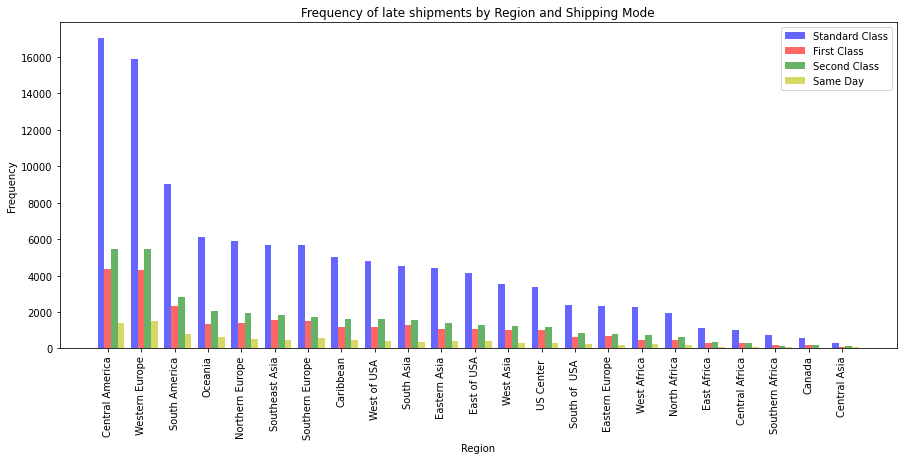

In [33]:
index = data.groupby('Order Region').count()['Sales'].sort_values(ascending=False).index
ticks = np.arange(len(index))

ship_data = data.groupby(['Shipping Mode', 'Order Region']).count()['Sales']
bar_width=0.2
opacity=0.6

# Plotting late deliveries by Shipping mode and region
fig,ax = plt.subplots(figsize=(15,6))
ax.bar(ticks, ship_data['Standard Class'].reindex(index), bar_width, alpha=opacity, color='b', 
       label='Standard Class')
ax.bar(ticks+bar_width, ship_data['First Class'].reindex(index), bar_width, alpha=opacity, color='r', 
       label='First Class')
ax.bar(ticks+2*bar_width, ship_data['Second Class'].reindex(index), bar_width, alpha=opacity, color='g', 
       label='Second Class')
ax.bar(ticks+3*bar_width, ship_data['Same Day'].reindex(index), bar_width, alpha=opacity, color='y', 
       label='Same Day')
ax.set(title='Frequency of late shipments by Region and Shipping Mode', xlabel='Region', ylabel='Frequency',
      xticks=ticks+bar_width)
ax.set_xticklabels(index, rotation=90)
ax.legend()
plt.show()

Not a surprise to see the maximum number of late deliveries in the Standard Shipping mode. Followed by Second Class and First Class which are close in terms of late deliveries. The least late deliveries are for Same Day mode. We can see that the costlier the delivery method, the higher the chance of on-time delivery.<br>
As for the regions, Central America has the highest late deliveries followed by Western Europe. Can we blame it on transportation infrastructure? Most probably.

### Customer Segmentation

Customer retention is at the heart of any business and an extremely crucial part of any supply chain business. We cannot imagine bohemoths like amazon.com being in business without great customer retention tactics.
In this section we look at ways in which we can identify churn and target certian groups of people for better retention.<br>
Since, purchase history of customers is already avaialble in the dataset, it can use RFM (Recency, Frequency, Monetary) analysis for customer segmention and indentification. We use the RFM technique because utilizes numerical values and the output is easy to interpret

In [34]:
# Last order:
data['order date (DateOrders)'] = pd.to_datetime(data['order date (DateOrders)'])
data['order date (DateOrders)'].sort_values(ascending=False)[0]

Timestamp('2018-01-31 22:56:00')

In [35]:
# To calculate recency, we set our present to 1 day after the last order
present = dt.datetime(2018,2,1)
# Total value per transaction - For monetary analysis
data['TotalPrice'] = data['Order Item Quantity'] * data['Order Item Total']

# Calculating the R, M and F values into a new dataframe
Customer_seg = data.groupby('Customer Id').agg({'order date (DateOrders)': lambda x: (present - x.max()).days, 
                                                'Order Id': 'count', 'TotalPrice': 'sum'})

Customer_seg['order date (DateOrders)'] = Customer_seg['order date (DateOrders)'].astype(int)
# Rename columns as R_Value,F_Value,M_Value
Customer_seg.rename(columns={'order date (DateOrders)': 'R_Value', 
                         'Order Id': 'F_Value', 
                         'TotalPrice': 'M_Value'}, inplace=True)
Customer_seg.head()

,R_Value,F_Value,M_Value
Customer Id,,,
1,792,1,2362.250061
2,136,10,2842.700073
3,229,18,6143.760057
4,380,14,4370.629991
5,457,7,2993.790032


R_Value(Recency) indicates how much time elapsed since a customer last order.<br>

F_Value(Frequency) indicates how many times a customer ordered.<br>

M_Value(Monetary value) tells us how much a customer has spent purchasing items.<br>

Lets take a look at the distributions of R, F and M values

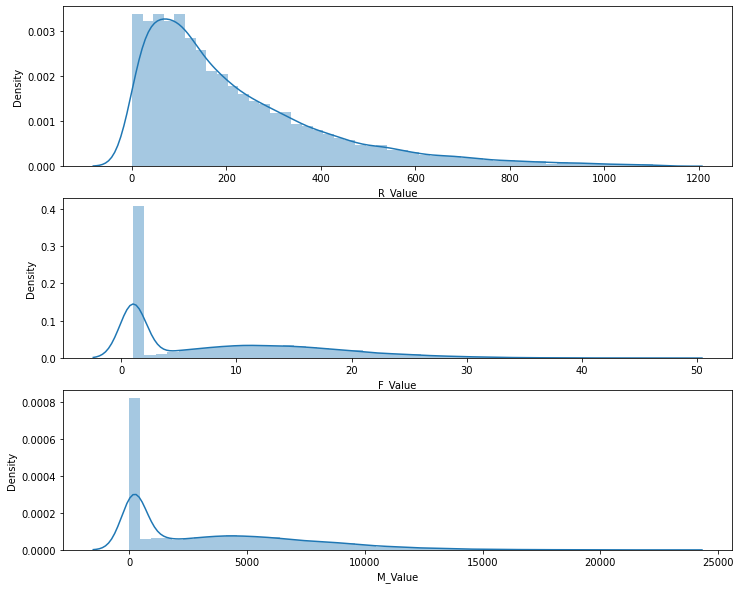

In [36]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10))
sns.distplot(Customer_seg['R_Value'], ax=ax[0])
sns.distplot(Customer_seg['F_Value'], ax=ax[1])
sns.distplot(Customer_seg['M_Value'], ax=ax[2])
plt.show()

In order to assess our customers based on the R, F and M scores, we combine these scores into a single score numerical figure which can be used to compare our customers.<br>
In order to do that, we first perform quantile binning on the R, F and M scores and get a 'quantile score'. Then aggregate the quantile scores into a single number

In [37]:
# Quantile binning RFM values into scores from 1 to 4
# Higher scores for larger F and M Values
# Lower scores for higher R values

Customer_seg['R_Score'] = pd.qcut(Customer_seg['R_Value'], q=4, labels=[4, 3, 2, 1])
# F score with 3 bins to preserve quantile arrangement
Customer_seg['F_Score'] = pd.qcut(Customer_seg['F_Value'], q=4, labels=[1, 2, 3], duplicates='drop')
Customer_seg['M_Score'] = pd.qcut(Customer_seg['M_Value'], q=4, labels=[1, 2, 3, 4])

print(Customer_seg['R_Score'].value_counts(), '\n', 
      Customer_seg['F_Score'].value_counts(), '\n',
      Customer_seg['M_Score'].value_counts())

4    5206
1    5159
3    5156
2    5131
Name: R_Score, dtype: int64 
 1    10615
2     5386
3     4651
Name: F_Score, dtype: int64 
 1    5182
4    5163
3    5163
2    5144
Name: M_Score, dtype: int64


In [38]:
# Creating aggregate RFM scores
Customer_seg['RFM_Score'] = Customer_seg.R_Score.astype(str)+ Customer_seg.F_Score.astype(str) + \
                            Customer_seg.M_Score.astype(str)
Customer_seg['RFM_Total'] = Customer_seg[['R_Score','F_Score','M_Score']].sum(axis=1)
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total
Customer Id,,,,,,,,
1,792,1,2362.250061,1,1,2,112,4
2,136,10,2842.700073,3,2,3,323,8
3,229,18,6143.760057,2,3,4,234,9
4,380,14,4370.629991,1,2,3,123,6
5,457,7,2993.790032,1,1,3,113,5


In [39]:
print(Customer_seg['RFM_Score'].unique())
print(Customer_seg['RFM_Total'].unique())

['112' '323' '234' '123' '113' '124' '334' '223' '111' '333' '134' '214'
 '133' '224' '122' '212' '233' '324' '322' '213' '312' '313' '222' '114'
 '211' '311' '412' '411']
[ 4  8  9  6  5  7 10  3]


We segment RFM totals into customer categories representing their levels of engagement with the company.

In [40]:
Customer_seg['Customer engagement'] = pd.cut(Customer_seg['RFM_Total'], bins=[0, 4, 5, 6, 7, 8, 10], 
                                             labels=['Lost', 'At Risk', 'Needs Attention', 'Promising', 
                                                     'Loyal Customers', 'Champions'])
Customer_seg.head()

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total,Customer engagement
Customer Id,,,,,,,,,
1,792,1,2362.250061,1,1,2,112,4,Lost
2,136,10,2842.700073,3,2,3,323,8,Loyal Customers
3,229,18,6143.760057,2,3,4,234,9,Champions
4,380,14,4370.629991,1,2,3,123,6,Needs Attention
5,457,7,2993.790032,1,1,3,113,5,At Risk


Lets do a visual analysis of the same

In [41]:
Customer_seg['Customer engagement'].value_counts()

Needs Attention    8083
Promising          3550
Champions          3261
Loyal Customers    2478
At Risk            2171
Lost               1109
Name: Customer engagement, dtype: int64

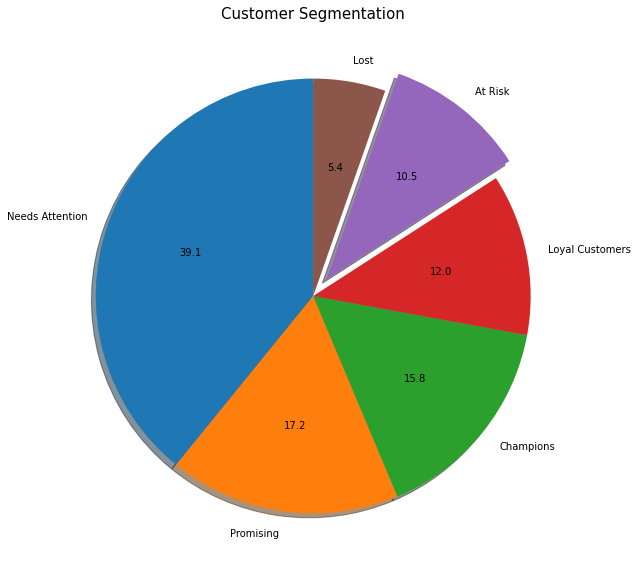

In [42]:
# Calculate average values for each RFM_Level, and return a size of each segment 
Customer_seg['Customer engagement'].value_counts().plot.pie(figsize=(10,10),
                                        startangle=90, explode=(0,0,0,0,0.1,0),autopct='%.1f', shadow=True)
plt.title("Customer Segmentation",size=15)
plt.ylabel(" ")
plt.show()

Based on the RFM segmentation technique, we see that nearly 10.5% of the customers are at risk of churn and nearly 39% need attention to be converted into promising customers. This can be done via promotional offers and discounts.<br>
We see that 5.4% of the customers are already lost.<br>

Lets take a look at out top 10 customers lost due to churn.

In [43]:
churned=Customer_seg[(Customer_seg['R_Score']==1)].sort_values(by='M_Score', ascending=False)[:10]
names = data[data['Customer Id'].isin(churned.index)][['Customer Full Name', 'Customer Id']].drop_duplicates()
churned['Name'] = names.set_index('Customer Id').reindex(churned.index)
churned

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total,Customer engagement,Name
Customer Id,,,,,,,,,,
12427,450,19,9884.340099,1,3,4,134,8,Loyal Customers,MarySmith
8999,408,22,7669.710029,1,3,4,134,8,Loyal Customers,PaulSmith
3692,351,17,6844.550079,1,3,4,134,8,Loyal Customers,JamesSmith
8953,463,16,6548.320008,1,3,4,134,8,Loyal Customers,EmmaAvila
3682,308,16,6483.410061,1,3,4,134,8,Loyal Customers,EmilyRomero
3680,563,20,8464.689995,1,3,4,134,8,Loyal Customers,DavidSmith
3678,338,26,9289.450132,1,3,4,134,8,Loyal Customers,AliceCastro
3675,528,18,9379.310013,1,3,4,134,8,Loyal Customers,JoycePittman
3671,318,16,7637.550013,1,3,4,134,8,Loyal Customers,MaryJohnson


These customers used to place orders with huge amounts very frequently but they did not place orders from almost a year which means they are purchasing from other companies. These groups of people should be targeted with offers to gain them back. Ofcourse we need to remove 'MarySmith' from the list.<br><br>

Top 10 recent customers with highest spending:

In [44]:
#The R_Score should be low and F_Score, M_Score should be as high as possible
new_best=Customer_seg[(Customer_seg['R_Score']==4)].sort_values(by='M_Score', ascending=False)[:10]
names = data[data['Customer Id'].isin(new_best.index)][['Customer Full Name', 'Customer Id']].drop_duplicates()
new_best['Name'] = names.set_index('Customer Id').reindex(new_best.index)
new_best

,R_Value,F_Value,M_Value,R_Score,F_Score,M_Score,RFM_Score,RFM_Total,Customer engagement,Name
Customer Id,,,,,,,,,,
15552,75,1,505.950012,4,1,2,412,7,Promising,JulieBenton
17960,40,1,353.529999,4,1,2,412,7,Promising,BethanyBright
17962,40,1,267.829987,4,1,2,412,7,Promising,OceanMeadows
17963,40,1,285.679993,4,1,2,412,7,Promising,AlexisPugh
17964,40,1,292.820007,4,1,2,412,7,Promising,ShelleyMcconnell
17965,40,1,296.390015,4,1,2,412,7,Promising,LeslieRatliff
17966,40,1,299.959992,4,1,2,412,7,Promising,QuailByrd
17967,40,1,303.540008,4,1,2,412,7,Promising,ZenaidaCurry
17968,40,1,310.679993,4,1,2,412,7,Promising,WillowCasey


These customers have the potential to become champions. They need to be paid attention to through loyalty programs and discounts and offers.<br>
Infact, all different customer segments can be targetted with tailored marketing and promotions based on the segments defined above.